In [18]:
# In the following we set up a PySCF driver, for the Li-H molecule at 
# equilibrium bond length (2.5 angstrom) in the singlet state and with no charge.

from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)

molecule = Molecule(
    geometry=[["Li", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 2.5]]], charge=0, multiplicity=1
)
driver = ElectronicStructureMoleculeDriver(
    molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF
)

In [19]:
# Here we set up the Electronic Structure Problem to generate the Second quantized operator 
# and a qubit converter that will map it to a qubit operator.
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper, BravyiKitaevMapper
# JordanWigner maps each fermonic operator to a spin operator ---maps each to a qubit
# Parity Mapper reduces number of qubits by 2

In [20]:
from qiskit_nature.settings import settings

settings.dict_aux_operators = True

In [21]:
# The below code prints out the Hamiltonian from above into terms of fermionic operators.
es_problem = ElectronicStructureProblem(driver)
second_q_op = es_problem.second_q_ops()
print(second_q_op["ElectronicEnergy"])

Fermionic Operator
register length=12, number terms=1860
  -4.60905426008936 * ( +_0 -_0 )
+ 0.09644507677079092 * ( +_0 -_1 )
+ 0.15894568824885427 * ( +_0 -_2 )
+ 0.0497193855300009 * ( +_0 -_5 )
+ 0.09644507677079074 * ( +_1 -_0 )
+ -1.21132290194413 ...


In [22]:
qubit_converter = QubitConverter(mapper=BravyiKitaevMapper())
qubit_op = qubit_converter.convert(second_q_op["ElectronicEnergy"])
print(qubit_op)

-4.959411017549166 * IIIIIIIIIIII
+ 0.9984281047897634 * IIIIIIIIIIIZ
- 0.012638766280126964 * IIIIIIIIIIZX
+ 0.012638766280126964 * IIIIIIIIIIIX
+ 0.023363462115235538 * IIIIIIIIIYYX
- 0.023363462115235538 * IIIIIIIIIXYY
+ 0.004818552105360592 * IIIIIIYIYIXX
- 0.004818552105360592 * IIIIIIXZYIXY
- 0.1284437609076145 * IIIIIIIIIIZZ
+ 0.00034538686097298 * IIIIIIIIIYYZ
+ 0.00034538686097298 * IIIIIIIIIXXI
+ 0.014656674233510136 * IIIIIIYIYIXZ
- 0.014656674233510136 * IIIIIIXZYIYI
- 0.19295222883701765 * IIIIIIIIIZII
- 0.018927578174948504 * IIIIIIYIYXZI
+ 0.018927578174948504 * IIIIIIXZYYZI
- 0.2352997868252999 * IIIIIIIIZZZI
- 0.2352997868252999 * IIIIIIIZIIII
- 0.27369382253456886 * IIIIIIZZIIII
+ 0.9984281047897631 * IIIIIZIIIIII
- 0.012638766280126943 * IIIIZXZIZIII
+ 0.012638766280126943 * IIIIIXIIIIII
+ 0.02336346211523553 * XIXYYXZIZIII
- 0.02336346211523553 * XIXXYYZIZIII
+ 0.004818552105360593 * YIIIYXZIZIII
- 0.004818552105360593 * XZZIYYZIZIII
- 0.12844376090761447 * IIIIZZZI

In [23]:
print(f'Number of qubits: {qubit_op.num_qubits}')

Number of qubits: 12


In [24]:
# Parity Mapper reduces number of qubits by 2
qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
qubit_op = qubit_converter.convert(
    second_q_op["ElectronicEnergy"], num_particles=es_problem.num_particles
)
print(qubit_op)

-4.9594110175491135 * IIIIIIIIII
+ 0.998428104789753 * IIIIIIIIIZ
- 0.012638766280126829 * IIIIIIIIZX
+ 0.012638766280126829 * IIIIIIIIIX
- 0.023363462115235288 * IIIIIIIZXX
- 0.023363462115235288 * IIIIIIIIYY
- 0.004818552105360566 * IIIIIXXXXX
- 0.004818552105360541 * IIIIIYXXXY
- 0.1284437609076131 * IIIIIIIIZZ
- 0.00034538686097297633 * IIIIIIIZXZ
+ 0.00034538686097297633 * IIIIIIIIXI
- 0.014656674233510058 * IIIIIXXXXZ
- 0.01465667423350998 * IIIIIYXXYI
- 0.19295222883701557 * IIIIIIIZZI
+ 0.0189275781749484 * IIIIIXXXZI
+ 0.018927578174948303 * IIIIIYXYII
- 0.23529978682529742 * IIIIIIZZII
- 0.23529978682529742 * IIIIIZZIII
- 0.2736938225345673 * IIIIIZIIII
+ 0.9984281047897575 * IIIIZIIIII
- 0.012638766280126877 * IIIZXIIIII
+ 0.01263876628012681 * IIIIXIIIII
- 0.023363462115235406 * IIZXXIIIII
- 0.02336346211523528 * IIIYYIIIII
- 0.004818552105360591 * XXXXXIIIII
- 0.004818552105360542 * YXXXYIIIII
- 0.12844376090761309 * IIIZZIIIII
- 0.00034538686097297503 * IIZXZIIIII
+ 0.000

In [25]:
print(f'Number of qubits: {qubit_op.num_qubits}')

Number of qubits: 10


In [26]:
# !pip install scikit-quant
#for optimizers: BOBYQA, IMFIL, SNOBFIT ---> though none of these were good so don't need it

In [27]:
import numpy as np
import pylab

from qiskit import Aer
from qiskit.opflow import X, Z, I
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP, CG
from qiskit.circuit.library import TwoLocal

In [28]:
qubit_op

TaperedPauliSumOp(SparsePauliOp(['IIIIIIIIII', 'IIIIIIIIIZ', 'IIIIIIIIZX', 'IIIIIIIIIX', 'IIIIIIIZXX', 'IIIIIIIIYY', 'IIIIIXXXXX', 'IIIIIYXXXY', 'IIIIIIIIZZ', 'IIIIIIIZXZ', 'IIIIIIIIXI', 'IIIIIXXXXZ', 'IIIIIYXXYI', 'IIIIIIIZZI', 'IIIIIXXXZI', 'IIIIIYXYII', 'IIIIIIZZII', 'IIIIIZZIII', 'IIIIIZIIII', 'IIIIZIIIII', 'IIIZXIIIII', 'IIIIXIIIII', 'IIZXXIIIII', 'IIIYYIIIII', 'XXXXXIIIII', 'YXXXYIIIII', 'IIIZZIIIII', 'IIZXZIIIII', 'IIIXIIIIII', 'XXXXZIIIII', 'YXXYIIIIII', 'IIZZIIIIII', 'XXXZIIIIII', 'YXYIIIIIII', 'IZZIIIIIII', 'ZZIIIIIIII', 'ZIIIIIIIII', 'IIIIIIIIZI', 'IIIIIIIZXI', 'IIIIIIIIXZ', 'IIIIIXXXXI', 'IIIIIYXXYZ', 'IIIIIIIZZZ', 'IIIIIXXXZZ', 'IIIIIYXYIZ', 'IIIIIIZZIZ', 'IIIIIZZIIZ', 'IIIIIZIIIZ', 'IIIIIIIZYY', 'IIIIIIIIXX', 'IIIIIXXXYY', 'IIIIIYXXYX', 'IIIIIIIZIX', 'IIIIIIIZZX', 'IIIIIXXYIY', 'IIIIIXXXIX', 'IIIIIYXYZX', 'IIIIIXXXZX', 'IIIIIYXYIX', 'IIIIIYXXIY', 'IIIIIIZZZX', 'IIIIIIZZIX', 'IIIIIZZIZX', 'IIIIIZZIIX', 'IIIIIZIIZX', 'IIIIIZIIIX', 'IIIIIXXYYX', 'IIIIIYXYYY', 'IIIIIIZIXX', '

In [29]:
optimizers = [COBYLA(maxiter=4000), L_BFGS_B(maxiter=4000), SLSQP(maxiter=1000), CG(maxiter=200)]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i, optimizer in enumerate(optimizers):
    print('\rOptimizer: {}        '.format(type(optimizer).__name__), end='')
    algorithm_globals.random_seed = 50
    ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')

    counts = []
    values = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
  
    vqe = VQE(ansatz, optimizer, callback=store_intermediate_result,
              quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
    result = vqe.compute_minimum_eigenvalue(operator=qubit_op)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
print('\rOptimization complete      ');

Optimization complete      


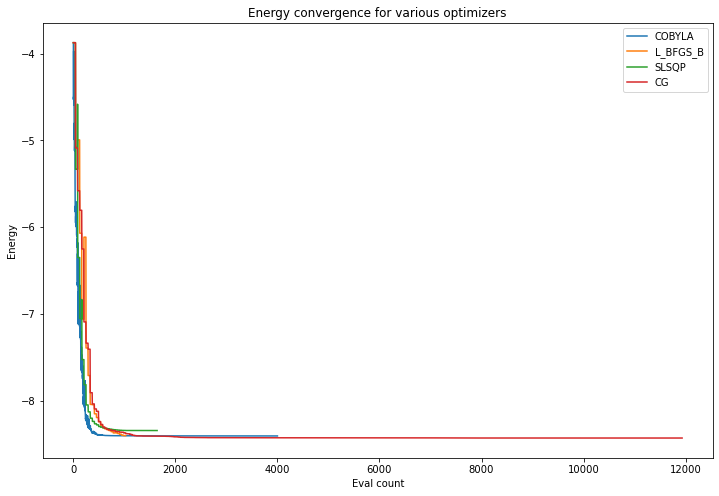

In [30]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right');

# GOOD ONES: COBYLA, L_BFGS_B,SLSQP, CG
# BAD ONES: ADAM, AQGD, SPSA, GSLS, GradientDescent, NFT, P_BFGS, POWELL, 
#             QNSPSA, NELDER_MEAD, TNC, SciPyOptimizer, UMDA, BOBYQA,IMFIL 

In [31]:
# NumPyMinimumEigensolver is used to computer a reference value of the LiH
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=qubit_op)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.5f}')

Reference value: -8.45874


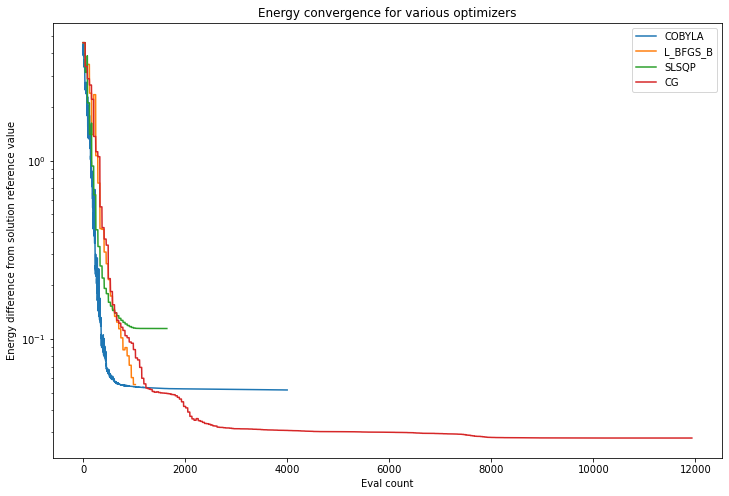

In [32]:
# The difference between the exact solution and the energy convergence using VQE can then be plotted
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], abs(ref_value - converge_vals[i]), label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy difference from solution reference value')
pylab.title('Energy convergence for various optimizers')
pylab.yscale('log')
pylab.legend(loc='upper right');

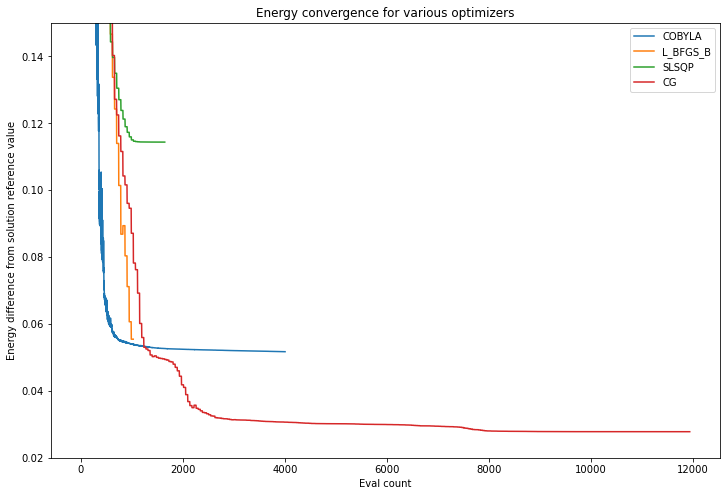

In [33]:
# The difference between the exact solution and the energy convergence using VQE can then be plotted
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], abs(ref_value - converge_vals[i]), label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy difference from solution reference value')
pylab.title('Energy convergence for various optimizers')
pylab.ylim(0.02,0.15)
pylab.legend(loc='upper right');